# 출차 시 사용될 코드

# library

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
import easyocr
import pandas as pd
import pymysql
from datetime import datetime

import utils_test

c:\Python3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'utils_test'

# Webcam

In [13]:
utils_test.webcam(0, 'outro_image')

# Yolo & OCR

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


클래스 번호:  0 
클래스: norm 
norm일 확률:  0.9996393322944641


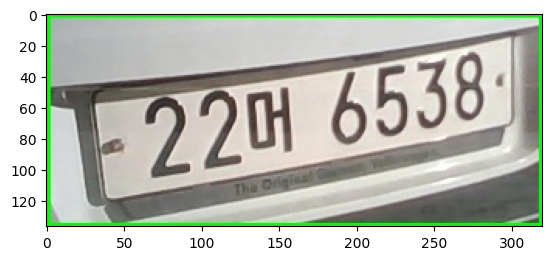

In [14]:

img_path = './image/outro_image/img.png'

img = cv2.imread(img_path)

with open('obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('yolov4-tiny-custom.cfg', 'yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

try : 
    classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

    clss = classIds.tolist()
    score = scores.tolist()

    # 주차딱지 변수 값 지정
    # Object Detection 했을 때 주차딱지가 Detection 안 되면 class_num_y = '0'값을 가짐
    # 주차딱지가 Detection 되면 class_num_y는 '3' 값을 가짐 (아래에 있는 if 문)

    class_num_y = '0'
    class_ev = '0'

    reader = easyocr.Reader(['ko'])

    # # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

    for i in range(len(clss)):
        box = boxes[i].tolist()
        w = box[0]
        h = box[1]
        x = box[2]
        y = box[3]
        bbox = img[h:y+h, w:x+w]


        if clss[i] == 0:
            print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])

            # 22.11.05  옮김 ㅎㅅㅇ
            class_num = str(clss[i])
            class_name = '일반'

            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            cv2.imwrite('./image/outro_image/norm.jpg', bbox) #저장
            norm = Image.open('./image/outro_image/norm.jpg')

            if bbox is None:
                print('Image load failed!')
                bbox.exit()
            
            norm_norm = Image.open("./image/outro_image/norm.jpg")
            plt.imshow(norm_norm)
            result = reader.readtext(norm_norm)
            
            if len(result[0][1]) <= 2:
                src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
                dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
                cv2.imwrite('./image/outro_image/norm_black.jpg', dst1)
                norm_black = Image.open('./image/outro_image/norm_black.jpg')
                result = reader.readtext(norm_black)
            
                if len(result) ==0:
                    norm_re = norm.resize((int(norm.width*2), int(norm.height)))         
                    norm_re.save('./image/outro_image/norm_re.jpg')
                    norm_re = cv2.imread('./image/outro_image/norm_re.jpg')
                    src_hsv = cv2.cvtColor(norm_re, cv2.COLOR_BGR2HSV)
                    dst1 = cv2.inRange(norm_re, (0, 0, 0), (120, 120, 120))
                    cv2.imwrite('./image/outro_image/norm_re_black.jpg', dst1)
                    norm_re_black = Image.open('./image/outro_image/norm_re_black.jpg')
                    result = reader.readtext(norm_re_black)
                    plt.imshow(norm_re_black)
                
        elif clss[i] == 1:
            print('클래스 번호: ', clss[i], '\n클래스: elec', '\nelec일 확률: ', score[i])

            class_num = str(clss[i])
            class_name = '전기'

            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            cv2.imwrite('./image/outro_image/elec.jpg', bbox)

            elec = Image.open('./image/outro_image/elec.jpg')

            if bbox is None:
                print('Image load failed!')
                bbox.exit()
                
            elec_norm = Image.open("./image/outro_image/elec.jpg")
            plt.imshow(elec_norm)
            result = reader.readtext(elec_norm)
            
            if len(result[0][1]) <= 2:
                src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
                dst1 = cv2.inRange(bbox, (0, 0, 0), (70, 80, 80))
                cv2.imwrite('./image/outro_image/elec_black.jpg', dst1)
                elec_black = Image.open('./image/outro_image/elec_black.jpg')
                result = reader.readtext(elec_black)
                
                if len(result) ==0:
                    elec_re = elec.resize((int(elec.width*2), int(elec.height)))         
                    elec_re.save('./image/outro_image/elec_re.jpg')
                    elec_re = cv2.imread('./image/outro_image/elec_re.jpg')
                    src_hsv = cv2.cvtColor(elec_re, cv2.COLOR_BGR2HSV)
                    dst1 = cv2.inRange(elec_re, (0, 0, 0), (130, 130, 130))
                    cv2.imwrite('./image/outro_image/elec_re_black.jpg', dst1)
                    elec_re_black = Image.open('./image/outro_image/elec_re_black.jpg')
                    result = reader.readtext(elec_re_black)
                    plt.imshow(elec_re_black)
                    
        if clss[i] == 2:
            print('클래스 번호: ', clss[i], '\n클래스: EV', '\nEV일 확률: ', score[i])
            class_ev = '1'

        if clss[i] == 3:
            print('클래스 번호: ', clss[i], '\n클래스: yellow', '\nyellow일 확률: ', score[i])
            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            class_num_y = '1'

    # -- 이미지 에러가 나면 출력할 구문
except :
  print('====IMG_ERR====')

In [ ]:
class_num = utils_test.norm_elec(class_num, class_ev)

# 문자추출

In [16]:
first_num, second_num = utils_test.result_plate(result)

In [17]:
print('차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)

차량번호 앞자리:  22머 
차량번호 뒷자리:  6538


# 출차 시간

In [18]:
out_time = utils_test.car_time()
out_time

'14:41'

# 주차 금액 정산

In [19]:
now = datetime.now()

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8')
    
# Dict형식의 CURSOR  
cur = conn.cursor(pymysql.cursors.DictCursor)

# SQL 작성 
sql_in = "select * from total_info"

# SQL 실행
cur.execute(query=sql_in)

# 결과 가져오기
result_in = cur.fetchall()

df_in = pd.DataFrame(result_in)

find = df_in[df_in['last_number'] == second_num]

price = utils_test.calc_price(find)
price

'00300'

# 주차요금 정산 후 total_info에서 해당 차량 정보 삭제

In [11]:
# 출차시 total_info에서 삭제 하는 구문 추가 ==> 같은 차량이 다시 주차하는 상황을 처리하기 위함.
cur.execute(f'delete from total_info where last_number = \"{second_num}\" ;')
conn.commit()

# outro_info 에 저장
## outro_info : 출차 시 LCD 모니터에 띄울 정보를 str 타입으로 된 한 줄의 정보를 저장하는 테이블

In [12]:
first_num = '{0:0>4}'.format(first_num)

In [13]:
conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8')

cur = conn.cursor()

#아랫줄은 제일 처음에 table 생성 시에만 사용함
#cur.execute("create table outro_info (outro_str varchar(30))")

cur.execute(f"insert into outro_info values(\"1{class_num_y}{class_num}{second_num}{first_num}{out_time}{price}\")")

conn.commit()
    

In [58]:
cur.execute('select * from total_info where last_number=%s;',second_num)
out_all=list(cur.fetchall()[0].values())
out_str=''
# print(out_all[0])
for i in range(4):
    out_str+=out_all[i]
out_str+=out_time
out_str+=price
print(out_str)

555044사0014:4213200
